In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
from scipy import interpolate
import functions as func

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f5f06jd1 because the default path (/home/codeastro/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [60]:
def read_isochrones(isoch_files):
    """Isochrone File Read

    Reads the Isochrone files.

    Args:
        isoch_files (file): .txt file. Isochrone models from the PARSEC-COLIBRI models (http://stev.oapd.inaf.it/cgi-bin/cmd).

    Returns:
        dictionary: dictionary with all the information of the Isochrone tables.
    """
    isochrones={}
    AGE=[]
    METALLICITY=[]

    for file_name in isoch_files:
        isoch_table=[]
        mylines = []                             # Declare an empty list named mylines.
        with open (file_name, 'rt') as myfile: # Open lorem.txt for reading text data.
            for myline in myfile:                # For each line, stored as myline,
                mylines.append(myline)           # add its contents to mylines.  
        #print(len(mylines))
        for i in range(len(mylines)):
            if mylines[i][0] == '#':
                continue
            isoch=mylines[i].split()
            for j in range(len(isoch)):
                isoch[j]=float(isoch[j])
            isoch_table.append(isoch) 
        #print(mylines[13].split()[1:])
        stellarpop=pd.DataFrame(isoch_table,columns=mylines[13].split()[1:])
        stellarpop=stellarpop[stellarpop['label']!=9]  # drop Post AGB points because those mess with star generation!
        logage=np.sort(stellarpop['logAge'].value_counts().index.tolist())
        MHs = np.sort(stellarpop['MH'].value_counts().index.tolist())
        #print(logage,MHs)
        AGE.append(logage)
        METALLICITY.append(MHs)
        for age in logage:
            for metallicity in MHs:
                isochrones[f'logAge:{age:.2f}_MH:{metallicity:.2f}']=[[age,metallicity],stellarpop[(stellarpop['logAge']==age) & (stellarpop['MH']==metallicity)]]
    parsec=[]
    return (isochrones)


In [61]:
def IMF_Kroupa(mass_lower_bound, 
                mass_upper_bound, 
                n_mass_grid=1000000, 
                alpha = [.3,1.3,2.3]):

    """Initial mass function

    Calculates the Kroupa IMF.

    Args:
        mass_lower_bound (float): float. One number with the minimum mass the Kroupa IMF follows.
        mass_upper_bound (float): float. One number with the maximum mass the Kroupa IMF follows.
        n_mass_grid (int): integer. Number of the range of masses that the IMF will work with, between the minimum and maximum masses. Default is 1000000.
        alpha (array): numpy array. List of three elements, containing the slopes of the Kroupa IMF.

    Returns:
        array: distribution of masses of the IMF.
        array: distribution of the normalised IMF.
    """
    #mass_min = np.min(isochrone[1]['Mini'])
    #mass_max= np.max(isochrone[1]['Mini'])
    mass_min = mass_lower_bound
    mass_max = mass_upper_bound
    mass_grid = np.linspace(mass_min,mass_max, n_mass_grid) # create the mass grid    
    IMF = np.zeros(n_mass_grid, dtype = float)
    dy1 = (np.power(.5,-alpha[2])-np.power(.5,-alpha[1]))
    dy2 = dy1+(np.power(.08,-alpha[1])-np.power(.08,-alpha[0]))
    for i,mass in enumerate(mass_grid):
        #print(i,mass,alpha[1],IMF[i],np.power(mass,-alpha[0]))
        if         mass <= .08 : IMF[i]=np.power(mass,-alpha[0])+dy2
        elif .08 < mass <= .5  : IMF[i]=np.power(mass,-alpha[1])+dy1
        else                   : IMF[i]=np.power(mass,-alpha[2])
    #print(np.power(.5,-alpha[2]) )       
    IMF = IMF/np.sum(IMF)
    return mass_grid , IMF

In [62]:

def stellar_mass_generator(n_stars, mass_grid, IMF):
    """Mass generator

    Calculates the distribution of stars (through random choice) of the stars according to the IMF.

    Args:
        n_stars (int): integer. Number of stars that the function will process.
        mass_grid (array): numpy array. See IMF_Kroupa for details.
        IMF (array): numpy array. See IMF_Kroupa for details.
        
    Returns:
        array: Randomly generated masses taken from the IMF. 
    """
    generated_masses=np.random.choice(mass_grid, size=n_stars, replace=True, p=IMF) # generate new masses

    return(generated_masses)


In [63]:

def poisonModel_Prediction_unc(b,X):
    """Exponential function

    Calculates the value of an exponential curve through the matrix of multiplication.

    Args:
        X (array): numpy array. Design matrix of the exponetial curve.
        b (array): numpy array. Vertical matrix of the coefficents.
        
    Returns:
        array: Exponential curve with design matrix X and coeffients b.
    """
    yhat = np.exp(X @ b)
    return yhat

    
def add_uncerntaties(magnitudes,
                        fit_param, 
                        mag_feature, 
                        SN_feature):
    
    """Addition of the uncertainties

    Calculates the magnitude uncertainties for a given signal-to-noise of a feature.

    Args:
        magnitudes (array): numpy array. Ideal magnitudes from the Isochrones, in mag.
        uncertainty_param (list): python list with two lists. Each list represents the fitting parameter on the HST observational uncertainties. One list for each band. Default is [[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]]. Values specified for the F606Wmag and F814Wmag bands (respectively) in the
        mag_feature (array): numpy array with two values. Absolute magnitude of a stellar phase you want to observe with a specific signal-to-noise. One number for each band. Default is [4, 5] (Representing the main sequence turn-off). Values specified for the F606Wmag and F814Wmag bands (respectively) in the 
        SN_feature (array): numpy array with two values. Photometry signal-to-noise of the absoulte magnitude feature of a stellar phase you want to observe. One number for each band. Default is [10, 10].
        
    Returns:
        array: magnitude with uncertainties
    """
    
    # OUTPUT: 
    
    # mag_with_unc: Input magnitudes + randon gaussian uncertainties
    # delta_m_final: Sigma of random gaussian uncertainties
    # exp_time_final: The ratio of needed exposure time to the exposure time of the reference data to get to SN_feature for mag_feature
    
    Xn = np.c_[np.ones(magnitudes.size), magnitudes]
    delta_m_initial = poisonModel_Prediction_unc(fit_param, Xn)
    delta_m_feature_initial = poisonModel_Prediction_unc(fit_param, np.c_[np.ones(1), mag_feature])
    
    SN_feature_initial = 1/(10**(-.4*(-delta_m_feature_initial))-1)
    exp_time_initial = 1
    exp_time_final = exp_time_initial*(SN_feature/SN_feature_initial)**2
    delta_m_final = np.abs(-2.5*np.log10(1 + ( (exp_time_initial/exp_time_final)**.5*(10**(-.4*-delta_m_initial)-1) ) ))
    mag_with_unc = np.random.normal(magnitudes, delta_m_final, magnitudes.shape[0])
    #return mag_with_unc,delta_m_final,exp_time_final
    return mag_with_unc,delta_m_final,exp_time_final


In [64]:
def SSP_generator(isoch_file, 
                    bands, 
                    n_stars, 
                    distandmodulus = 0,
                    uncertainty = True,
                    absolute_mag_features = np.array([4 , 5]),
                    SN_feature = [10,10],
                    uncertainty_param = [[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]],
                    plot = True): 
    # Input isochrone_table should be a dataframe.
    # Input n_star is the number of generated stars.
    """SSP Generator

    Generates a Simple Stellar Population from an Isochrone. Can also produce Color-Magnitude diagram of this SSP.

    Args:
        isochrone_file (file): .txt file. Isochrone models from the PARSEC-COLIBRI models (http://stev.oapd.inaf.it/cgi-bin/cmd).
        bands (list): python list of strings. A list with two strings that contains the name of two bands, necessary for the production of the Color-Magnitude diagram. The first band must have shorter wavelengths than the second band.
        n_stars (int): integer. Number of stars that the function will process.
        distandmodulus (float): float. Distance modulus from us to the cluster. Unitless. Default is 0 (All stars have absolute magnitude).
        uncertainity (boolean). Default is True, where it considers observational effects (simulated by HST observations), dispersing the data. If False, gives the Isochrone line.
        absolute_mag_features (array): numpy array with two values. Absolute magnitude of a stellar phase you want to observe with a specific signal-to-noise. One number for each band. Default is [4, 5] (Representing the main sequence turn-off). Values specified for the F606Wmag and F814Wmag bands (respectively) in the 
        SN_feature (array): numpy array with two values. Photometry signal-to-noise of the absoulte magnitude feature of a stellar phase you want to observe. One number for each band. Default is [10, 10].
        uncertainty_param (list): python list with two lists. Each list represents the fitting parameter on the HST observational uncertainties. One list for each band. Default is [[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]]. Values specified for the F606Wmag and F814Wmag bands (respectively) in the
        plot (boolean). Default is True, where the SSP is plotted onto a Color-Magnitude diagram.
        
    Returns:
        plot (optional): Plot of the Color-magnitude diagram of the SSP.
        DataFrame: SSP data, including the stellar mass, age, metallicity and the magnitudes of the bands specified.
    """
    isochrones = read_isochrones(isoch_file)
    isochrone_names=list(isochrones.keys())

    isochrone_table = isochrones[isochrone_names[0]]
    
    mass_lower_bound = np.min(isochrone_table[1]['Mini'])
    mass_upper_bound= np.max(isochrone_table[1]['Mini'])
    
    #IMF = IMF_Kroupa(mass_lower_bound = mass_lower_bound, mass_upper_bound = mass_upper_bound)
    mass_grid , IMF = IMF_Kroupa(mass_lower_bound = mass_lower_bound, 
                                    mass_upper_bound = mass_upper_bound, 
                                    n_mass_grid=1000000, 
                                    alpha = [.3,1.3,2.3])
    
    #new_masses=random.choices(mass_bin, weights=IMF, k=n_stars) # generate new masses
    #new_masses=np.random.choice(mass_bin, weights=IMF, k=n_stars) # generate new masses
    new_masses = stellar_mass_generator(n_stars, mass_grid , IMF) # generate new masses


    SSP = pd.DataFrame(new_masses , columns=['Mini'])           # make a df for the SSP

    logAge = isochrone_table[0][0]
    SSP['logAge']= np.full(n_stars,logAge)

    MH = isochrone_table[0][1]
    SSP['MH']= np.full(n_stars,MH)
    
    for band in bands:
        x = isochrone_table[1]['Mini']
        y = isochrone_table[1][band]
        f = interpolate.interp1d(x, y)
        #globals()[' %s' % band] = f(new_masses) 
        SSP[band] = f(new_masses)  # estimate the mags for the generated masses and add to the SSP

        SSP[band] += distandmodulus
    


    #print('distandmodulus= ', distandmodulus)
    mag_feature = absolute_mag_features + distandmodulus
    SN_feature = [10,10]
    #print('mag_feature=', mag_feature)

    bands_unc_coef=[[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]]  #IC1613

    colour_min = -1
    colour_max = 4

    magnitude_max = mag_feature
    magnitude_min = magnitude_max - 10
    if uncertainty == True:
        for b,band in enumerate(bands):
            SSP[band] = SSP[( SSP[bands[1]] < magnitude_max[1]+1.193 )][band]
            SSP[band] = add_uncerntaties(SSP[band],fit_param = uncertainty_param[b], mag_feature = mag_feature[b], SN_feature = SN_feature[b])[0]
            SSP[band] = SSP[( SSP[bands[1]] < magnitude_max[1]+1.193 )][band]
    
    SSP = SSP.dropna() 


    if plot == True:
        a = SSP[bands[0]]
        b = SSP[bands[1]]

        x = a-b
        y = b

        #plt.scatter(x,y,s=10,c=SSP['Mini'])
        plt.scatter(x,y,s=1)
        #plt.scatter(stellarpop.F555Wmag-stellarpop.F814Wmag,stellarpop.F814Wmag,c=stellarpop.Mass,s=5, cmap='cool') #,label='logAGE=%.2f'%(logAGE)
        plt.gca().invert_yaxis()
        plt.xlabel(f'{bands[0]}-{bands[1]}')  #don't forget chanfe the axis title if you chose different bands!
        pl.rcParams["figure.figsize"] = (8,8)
        plt.xlim(colour_min,2)
        #print(magnitude_max[1],magnitude_min[0])
        #plt.ylim(magnitude_max[1],magnitude_min[0])
        plt.ylabel(f'{bands[1]}')
        plt.legend()
        plt.show()
    return SSP

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


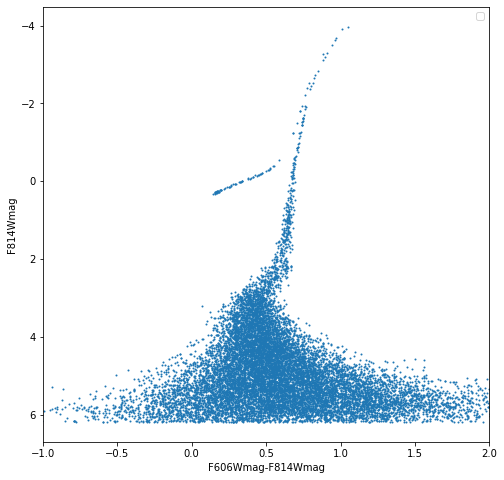

In [65]:
isoch_files=['iso0.txt']
bands=['F606Wmag','F814Wmag']
SSP = SSP_generator(isoch_files, bands=bands, n_stars = 100000, distandmodulus = 0, uncertainty = True, plot=True)

In [66]:
SSP

,Mini,logAge,MH,F606Wmag,F814Wmag
5,0.554739,10.07918,-2.0,7.154901,5.869754
19,0.620202,10.07918,-2.0,6.350557,5.515805
28,0.585309,10.07918,-2.0,6.315607,5.394714
36,0.607650,10.07918,-2.0,5.427982,5.315715
39,0.635860,10.07918,-2.0,5.256909,5.418469
...,...,...,...,...,...
99971,0.622308,10.07918,-2.0,6.017284,5.566606
99973,0.731618,10.07918,-2.0,4.757492,4.238276
99987,0.697919,10.07918,-2.0,4.695963,4.598289
99988,0.613369,10.07918,-2.0,6.029281,5.715131


In [16]:
bands=['F606Wmag','F814Wmag']
SSP = SSP_generator(isochrones[isochrone_names[0]], bands, n_stars=10000 )#print(SSP.head())

NameError: name 'IMF_Kroupa' is not defined

In [13]:
SSP

NameError: name 'SSP' is not defined